In [2]:
import pickle
import numpy as np
import datetime as dt
import pandas as pd
from tpot import TPOTClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold

`X_train` = array of training data, `y_train` = labels, `group` = protein cmplx group

In [3]:
tpot_dir = '../ppi_ml/tpot/'
timestamp = dt.datetime.now().strftime('%Y-%m-%d')
outfile = tpot_dir+'tpot_pipeline_'+timestamp
outfile

'../ppi_ml/tpot/tpot_pipeline_2023-03-08'

In [4]:
fmatfile = '../ppi_ml/data/featmats/featmat_labeled_traintest.pkl'
with open(fmatfile, 'rb') as handle:
    fmat = pickle.load(handle)

In [5]:
label_cols = ['ID', 'label', 'super_group']
data_cols = [c for c in fmat.columns.values.tolist() if c not in label_cols]

In [6]:
fmat[label_cols[0]]

0        ENOG502QR6E ENOG502QPKB
1            KOG0217 ENOG502QPKB
2            ENOG502QPKB KOG0263
3            KOG2440 ENOG502QPKB
4            KOG3005 ENOG502QPKB
                  ...           
26511            KOG1894 KOG1597
26512            KOG1894 KOG1969
26513            KOG1894 KOG2691
26514            KOG1894 KOG3400
26515            KOG1894 KOG3342
Name: ID, Length: 26516, dtype: object

In [7]:
X = fmat[data_cols].to_numpy()
y = fmat[label_cols[1]].to_numpy()
groups = fmat[label_cols[2]].to_numpy()

In [8]:
gss = GroupShuffleSplit(n_splits=3, train_size=0.7, random_state=13)
gss.get_n_splits()
for i, (test_index, train_index) in enumerate(gss.split(X, y, groups)):
    print(f"Fold {i}:")
    print(f"\tTrain: index={train_index}, group={groups[train_index]}")
    print(f"\tTest:  index={test_index}, group={groups[test_index]}")
    print(f"\t # train PPIs = {len(X[train_index])}")
    print(f"\t # test PPIs = {len(X[test_index])}")

Fold 0:
	Train: index=[    1     2     3 ... 26513 26514 26515], group=[  1   1  47 ...   1   1 494]
	Test:  index=[    0     6     8 ... 26498 26500 26502], group=[ 511   17   56 ... 1132    7   56]
	 # train PPIs = 19176
	 # test PPIs = 7340
Fold 1:
	Train: index=[    0     1     2 ... 26513 26514 26515], group=[511   1   1 ...   1   1 494]
	Test:  index=[    3     6     8 ... 26506 26509 26510], group=[47 17 56 ... 63 10 55]
	 # train PPIs = 18011
	 # test PPIs = 8505
Fold 2:
	Train: index=[    1     2     4 ... 26513 26514 26515], group=[  1   1   1 ...   1   1 494]
	Test:  index=[    0     3     8 ... 26506 26509 26510], group=[511  47  56 ...  63  10  55]
	 # train PPIs = 18649
	 # test PPIs = 7867


In [9]:
idx = gss.split(X, y, groups)
idx

<generator object BaseShuffleSplit.split at 0x7f05d8132a40>

In [10]:
for test_idx, train_idx in gss.split(X, y, groups):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

# check split & label balance
label, counts = np.unique(y_train, return_counts=True)
label_counts_train = dict(zip(label, counts))
label, counts = np.unique(y_test, return_counts=True)
label_counts_test = dict(zip(label, counts))
print(f'# train PPIs = {len(X_train)}')
print(f' --> +/- label balance: {label_counts_train}')
print(f'# test PPIs = {len(X_test)}')
print(f' --> +/- label balance: {label_counts_test}')

# train PPIs = 18649
 --> +/- label balance: {-1: 14065, 1: 4584}
# test PPIs = 7867
 --> +/- label balance: {-1: 5822, 1: 2045}


# Running TPOT

In [11]:
pipeline_opt = TPOTClassifier()
pipeline_opt = TPOTClassifier(generations=1, population_size=1, cv=5,
                                    random_state=13, verbosity=2)

In [12]:
pipeline_opt.fit(X_train, y_train) 
print(pipeline_opt.score(X_test, y_test))

Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.876670455534011

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.35000000000000003, min_samples_leaf=3, min_samples_split=14, n_estimators=100)
0.8929706368374222


/stor/home/rmcox/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:794: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(


In [31]:
import pickle
clf = pipeline_opt.fitted_pipeline_
with open('/stor/work/Marcotte/project/rmcox/leca/ppi_ml/results/tpot/tpot_model_test.pkl', 'wb') as f:
    pickle.dump(clf,f)

In [12]:
pipeline_opt.fit(X_train, y_train)
print(pipeline_opt.score(X_test, y_test))
pipeline_opt.export(outfile)

Optimization Progress:   0%|          | 0/220 [00:00<?, ?pipeline/s]



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.35000000000000003, min_samples_leaf=3, min_samples_split=14, n_estimators=100)


NameError: name 'X_test' is not defined

# Running optimized model

In [78]:
# clf = ExtraTreesClassifier(bootstrap=True, 
#                            criterion="gini", 
#                            max_features=0.7,
#                            min_samples_leaf=3, 
#                            min_samples_split=14, 
#                            n_estimators=100,
#                            n_jobs=8,
#                            random_state=13)

In [33]:
with open('/stor/work/Marcotte/project/rmcox/leca/ppi_ml/results/tpot/tpot_model_test.pkl', 'rb') as f:
    clf = pickle.load(f)

In [34]:
clf.fit(X_train, y_train)
clf.predict(X_test)

array([-1, -1, -1, ..., -1, -1, -1])

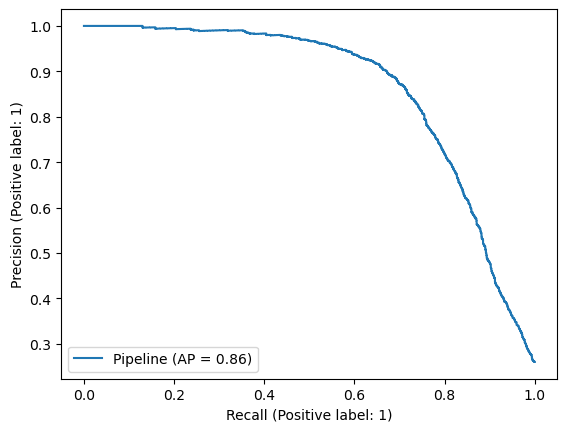

In [35]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

In [83]:
y_score = clf.predict_proba(X_test)
y_score

array([[0.77590254, 0.22409746],
       [0.9514414 , 0.0485586 ],
       [0.97514164, 0.02485836],
       ...,
       [0.39176456, 0.60823544],
       [0.78733025, 0.21266975],
       [0.89556254, 0.10443746]])

In [84]:
prob = np.split(y_score, 2, axis=1)

In [85]:
neg_prob = prob[0]
pos_prob = prob[1]

In [89]:
ids = fmat[label_cols[0]][test_index]
ids

0        ENOG502QR6E ENOG502QPKB
2            KOG0803 ENOG502QPKB
4            KOG2937 ENOG502QPKB
10           ENOG502QPKK KOG1255
18           ENOG502QPKK KOG2054
                  ...           
25221        ENOG502QVHA KOG3432
25227            KOG0588 KOG1804
25229            KOG3593 KOG1746
25230        KOG0729 ENOG502QTQ3
25232        ENOG502QR7Y KOG0791
Name: ID, Length: 7477, dtype: object

In [90]:
df = pd.DataFrame()
df['ID'] = ids
df['label'] = y_test
df['ppi_score'] = pos_prob
df.sort_values('ppi_score', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)

In [95]:
print(f"Computing precision/recall ...")
tp_count = 0
fp_count = 0
p_list = []
r_list = []
f_list = []
all_pos = len(df[df['label'] == 1])

for i in range(len(df)):

    if df['label'][i] == 1:
        tp_count += 1
    else:
        fp_count += 1

    tps = tp_count
    fps = fp_count
    fns = all_pos - tps

    precision = tps/(tps+fps)
    recall = tps/(tps+fns)
    fdr = 1 - precision

    p_list.append(float(precision))
    r_list.append(float(recall))
    f_list.append(float(fdr))

Computing precision/recall ...


In [99]:
df['precision'] = p_list
df['recall'] = r_list
df['fdr'] = f_list
df

,ID,label,ppi_score,precision,recall,fdr
0,KOG3409 KOG1068,1,0.996235,1.000000,0.000489,0.000000
1,KOG3250 KOG2582,1,0.995565,1.000000,0.000978,0.000000
2,KOG2206 KOG1612,1,0.994682,1.000000,0.001467,0.000000
3,KOG1068 KOG1004,1,0.993239,1.000000,0.001956,0.000000
4,KOG3409 KOG3013,1,0.993235,1.000000,0.002445,0.000000
...,...,...,...,...,...,...
7472,KOG4664 KOG2396,-1,0.000000,0.273652,1.000000,0.726348
7473,KOG4832 KOG3289,-1,0.000000,0.273615,1.000000,0.726385
7474,KOG0428 KOG0478,-1,0.000000,0.273579,1.000000,0.726421
7475,KOG0934 KOG2736,-1,0.000000,0.273542,1.000000,0.726458


In [112]:
thres_df = df[df['fdr'] <= 0.15]
cutoff = min(thres_df['ppi_score'])

<AxesSubplot: xlabel='recall', ylabel='precision'>

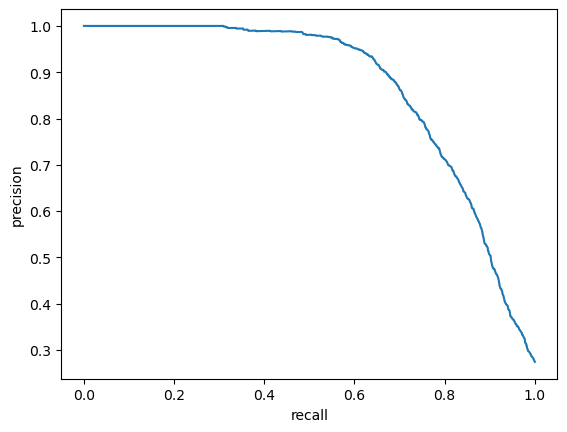

In [101]:
import seaborn as sns
sns.lineplot(data=df, x="recall", y="precision")

In [104]:
full_fmatfile = '../ppi_ml/data/featmats/featmat_labeled.pkl'
with open(full_fmatfile, 'rb') as handle:
    full_fmat = pickle.load(handle)

In [106]:
fmat_pred = full_fmat[full_fmat['label'] == 0]

In [122]:
ids_pred = fmat_pred[label_cols[0]]
ids_pred

0          ENOG502QPIC ENOG502QR7H
1              KOG0253 ENOG502QPIC
2              KOG0734 ENOG502QPIC
3              ENOG502QPIC KOG0739
4              KOG0935 ENOG502QPIC
                    ...           
4491713        ENOG502RYI9 KOG3271
4491714        ENOG502RYI9 KOG3274
4491715        ENOG502RYI9 KOG3394
4491716        ENOG502RYI9 KOG3855
4491717            KOG3873 KOG4679
Name: ID, Length: 4466477, dtype: object

In [108]:
X_pred = fmat_pred[data_cols].to_numpy()

In [109]:
y_score_pred = clf.predict_proba(X_pred)

In [116]:
prob_pred = np.split(y_score_pred, 2, axis=1)
prob_pos_pred = prob_pred[1]
prob_pos_pred

array([[0.01082579],
       [0.01477855],
       [0.06182741],
       ...,
       [0.1068567 ],
       [0.11705963],
       [0.09565432]])

In [123]:
df_pred = pd.DataFrame()
df_pred['ID'] = ids_pred
df_pred['ppi_score'] = prob_pos_pred
df_pred

,ID,ppi_score
0,ENOG502QPIC ENOG502QR7H,0.010826
1,KOG0253 ENOG502QPIC,0.014779
2,KOG0734 ENOG502QPIC,0.061827
3,ENOG502QPIC KOG0739,0.028038
4,KOG0935 ENOG502QPIC,0.017406
...,...,...
4491713,ENOG502RYI9 KOG3271,0.067741
4491714,ENOG502RYI9 KOG3274,0.109429
4491715,ENOG502RYI9 KOG3394,0.106857
4491716,ENOG502RYI9 KOG3855,0.117060


In [126]:
res = df_pred[df_pred['ppi_score'] >= cutoff]

In [128]:
final_ids = res['ID'].str.split(' ', expand=True)

In [130]:
len(np.unique(final_ids[[0, 1]].values))

3555

# Testing exported pipeline integration

In [149]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
#tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
#features = tpot_data.drop('target', axis=1)
#training_features, testing_features, training_target, testing_target = \
#            train_test_split(features, tpot_data['target'], random_state=13)

# Average CV score on the training set was: 0.9280164335087641
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=1.0, min_samples_leaf=5, min_samples_split=14, n_estimators=100)
)

In [150]:
exported_pipeline.fit(X_train, y_train)

Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('extratreesclassifier',
                 ExtraTreesClassifier(max_features=1.0, min_samples_leaf=5,
                                      min_samples_split=14))])

In [151]:
exported_pipeline.predict(X_test)

array([-1, -1, -1, ..., -1, -1, -1])

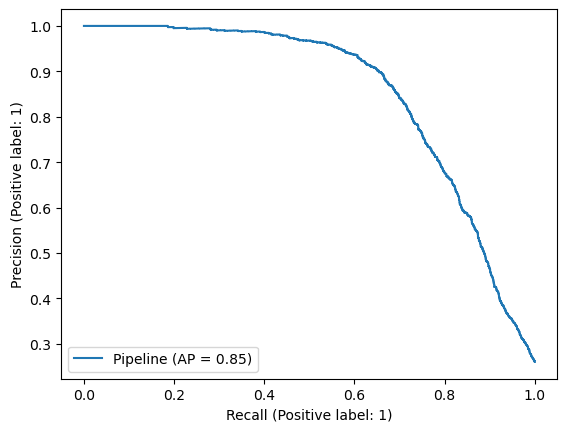

In [152]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(exported_pipeline, X_test, y_test)